In [1]:
import networkx as nx
import numpy as np
import warnings
import datetime as dt

import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('axes', axisbelow=True)

# Introduction to Network Resilience

...from **Resilience and evolvability of protein-protein interaction networks**, by Brennan Klein, Ludvig Holmér, Keith M. Smith, Mackenzie M. Johnson, Anshuman Swain, Laura Stolp, Ashley I. Teufel, and April S. Kleppe (2020):

#### Modified Shannon diversity
The *network resilience*, $R$, is an information theoretic measure that describes the extent to which random node removal deteriorates network structure (**[Zitnik et al., 2019](https://www.pnas.org/content/116/10/4426)**). It is computed by iteratively removing a fraction, $f$, of the nodes in the network and calculating a modified Shannon diversity measure for the resulting network. For a network of size $N$, this is:
$$H_{msh}(G) = -\dfrac{1}{\log(N)} \displaystyle \sum_{x = 1}^{X} p_{x} \log p_{x}$$
where $p_{x} = \frac{|c_{x}|}{N}$ and $c_{x}$ is a connected component; $p_{x}$, therefore, is the probability that a randomly selected node is in the connected component $c_{x}$.

#### Network resilience
The resilience of a network, $G$, is computed by iteratively removing a fraction, $f$, of nodes in the network (each time, this creates at least one new disconnected component, $c_x$, of size $|c_x|=1$). As $f$ increases from $0$ to $1$, the network becomes more and more disconnected until $f=1$, at which point the resulting network, $G_{f=1}$, is a collection of $N$ disconnected nodes. The Shannon diversity of these component size distributions increases as $f$ increases. The final value for resilience is then calculated as the area under this curve:
$$R(G) = 1 - \displaystyle\sum_{f=0}^{1} \dfrac{H_{msh}(G_f)}{r_f}$$
where $r_f$ is the number of $f$ values (i.e, if $r_f=100$, we remove 1\%, 2\%, ... 100\% of the nodes) and $H_{msh}(G_f)$ is the modified Shannon diversity of the network after $f$ fraction of nodes have been disconnected. Dense Erdös-Rényi networks are more resilient than sparse ones, which conforms to the intuition that a complete network is the most resilient network, with a value $R(G)=0.5$.

In [40]:
G_yeast = nx.read_graphml('../data/G_sce.graphml')
G_ecoli = nx.read_graphml('../data/G_eco.graphml')
G_human = nx.read_graphml('../data/G_hsa.graphml')

In [41]:
def modified_shannon_entropy(G, f, removal='random',
                             niter=50, return_stdv=False):
    """
    After a fraction, f, nodes have been 'removed' from the network (i.e., they
    have become disconnected isolates, such that the number of nodes does not
    change), this measure corresponds to the entropy of the distribution of
    component sizes, P(C). That is, P(c_i) corresponds to the probability that
    a randomly selected node will be in component c_i; there is a higher
    probability that a randomly-selected node will be in larger components.

    Parameters
    ----------
    G (nx.Graph):
        the graph in question.

    f (float):
        the fraction of N nodes in the network to be removed.

    removal (str):
        the method by which nodes are removed from the network.

    ntimes (int):
        the number of times to remove nodes to compute the mean entropy.

    return_stdv (bool):
        if True, this function returns a mean entropy as well as the standard
        deviation of the entropy after running ntimes. if False, this function
        just returns the mean value for the entropy.

    Returns
    -------
    H_msh_mean (float):
        the modified Shannon entropy averaged over ntimes runs. if return_stdv,
        this function also returns H_msh_stdv.

    """
    H_msh_mean = []
    for _ in range(niter):
        out_H = []
        N = G.number_of_nodes()
        leading_term = -1 / np.log2(N)
        p_i_unif = 1 / N

        G_f = G.copy()

        if removal == 'random':
            remove_nodes = [i for i in G_f.nodes() if np.random.rand() < f]

        else:
            warnings.warn("Only implemented for *random*. switching to that.")
            remove_nodes = [i for i in G_f.nodes() if np.random.rand() < f]

        curr = 0

        if len(remove_nodes):
            for node_r in remove_nodes:
                G_f.remove_node(node_r)
                curr += p_i_unif * np.log2(p_i_unif)

        Cs = list(nx.connected_components(G_f))
        for Ci in Cs:
            p_i = len(Ci) / N
            curr += p_i * np.log2(p_i)

        out_H.append(curr)

        H_msh = np.abs(leading_term * np.sum(out_H))
        H_msh_mean.append(H_msh)

    if return_stdv and niter > 4:

        return np.array(H_msh_mean).mean(), np.array(H_msh_mean).std()

    else:
        return np.array(H_msh_mean).mean()

In [42]:
G1 = nx.karate_club_graph()
G2 = nx.erdos_renyi_graph(G1.number_of_nodes(),nx.density(G1))
G3 = nx.barabasi_albert_graph(G1.number_of_nodes(),int(nx.density(G1)*G1.number_of_nodes()/2))

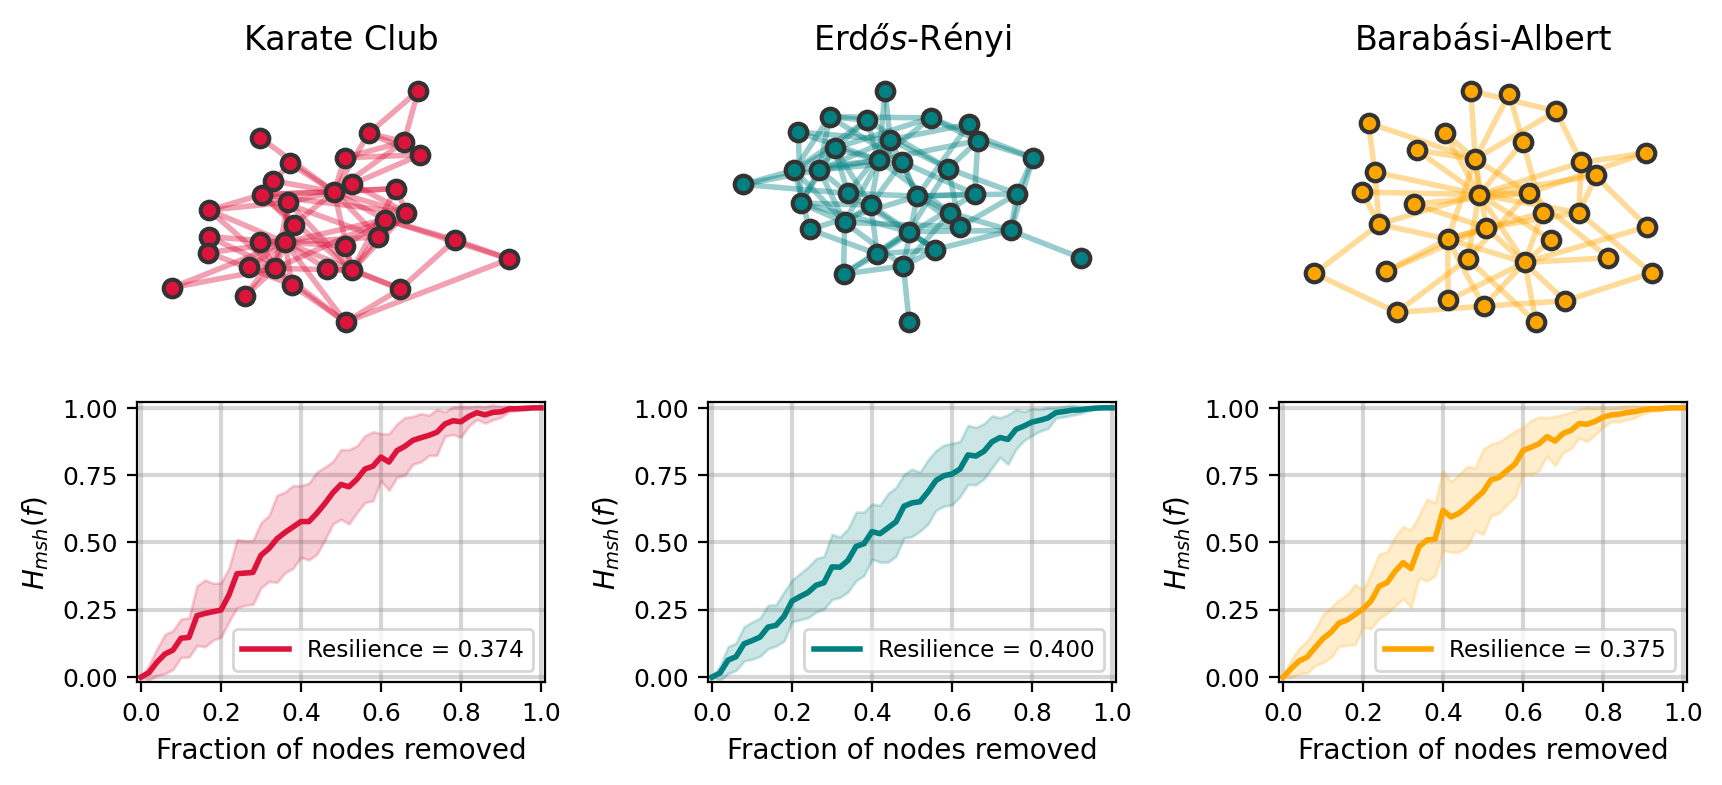

In [43]:
rate = 51
rates = np.linspace(0, 1, rate)
graphs = [G1, G2, G3]
cols = ['crimson', 'teal', 'orange']
titles = ['Karate Club', r'Erd$o\H{s}$-Rényi', 'Barabási-Albert']

fig, ax = plt.subplots(2, 3, figsize=(10,4), dpi=200)
plt.subplots_adjust(wspace=0.4, hspace=0.2)

for i, Gi in enumerate(graphs):
    Hout_m = []
    Hout_s = []
    for f in rates:
        Hsm, Hss = modified_shannon_entropy(Gi, f, removal='random', return_stdv=True)
        Hout_m.append(Hsm)
        Hout_s.append(Hss)

    means = np.array(Hout_m)
    stdvs = np.array(Hout_s)
    
    res = 1 - sum(means) / rate
    ax[(1,i)].plot(rates, means, color=cols[i],
                   linewidth=2, label='Resilience = %.3f'%res)
    ax[(1,i)].fill_between(rates, means-stdvs, means+stdvs,
                           alpha=0.2, color=cols[i])
    
    ax[(1,i)].set_xlabel('Fraction of nodes removed')
    ax[(1,i)].set_xticks(np.linspace(0,1,6).round(2))
    ax[(1,i)].set_xlim(-0.01,1.01) 

    ax[(1,i)].set_ylabel(r'$H_{msh}(f)$')
    ax[(1,i)].set_yticks(np.linspace(0,1,5).round(2))
    ax[(1,i)].set_ylim(-0.02,1.02) 

    ax[(1,i)].grid(color='#999999', linewidth=1.5, alpha=0.4)
    ax[(1,i)].legend(fontsize='small')

    pos = nx.kamada_kawai_layout(Gi)
    nx.draw_networkx_nodes(Gi, pos, ax=ax[(0,i)], node_size=40, linewidths=1.5,
                           node_color=cols[i], edgecolors='#333333')
    nx.draw_networkx_edges(Gi, pos, ax=ax[(0,i)], edge_color=cols[i],
                           alpha=0.4, width=2)
    ax[(0,i)].set_title(titles[i])
    ax[(0,i)].set_axis_off()

for qi,a in enumerate(fig.axes):
    a.tick_params(axis='both', bottom=True, labelsize=9,
                  labelbottom=True, left=True, labelleft=True)

plt.savefig("../figs/pngs/resilience_intro_threegraphs.png", dpi=600, bbox_inches='tight')
plt.savefig("../figs/pdfs/resilience_intro_threegraphs.pdf", bbox_inches='tight')

plt.show()

In [44]:
def resilience(G, ntimes=10, rate=50, output_list=True, removal='random',
               H_std=True, niter=50):
    """
    The resilience of a network, G, is defined as the Shannon
    entropy of the cluster size distribution of a graph at a given
    time, t. By repeatedly removing a fraction of random nodes at each
    timestep, we observe the change of this distribution and, as such
    the entropy, H_sh. The resilience is calculated as the 1-sum(H_sh).

    Parameters
    ----------
    G (nx.Graph):
        the graph in question.

    n_times (int):
        the number of runs that the algorithm goes through in order to arrive
        at the final (averaged) entropy value.

    rate (int):
        the number of intervals between 0 and 1, which correspond to fractions
        of the network that are removed at each step.

    output_list (bool):
        if True, returns a list of resilience values. else, returns one value.
.
    removal (str):
        method of node-removal. for now this only includes 'random', but one
        can imagine a number of ways to systematically bias the node-removal
        process (e.g. based preferentially on degree, etc.)

    Returns
    -------
    out_mean (list or float):
        if output_list==True, this function returns a list of length = rate
        entropy values, which forms the curve that is used to calculate the
        network resilience. else, it returns 1 - sum(out_mean)/rate.

    """

    out_mean = []
    out_stdv = []
    for _ in range(ntimes):
        H_out_mean = []
        H_out_stdv = []
        for f in np.linspace(0, 1, rate):
            H_msh_mean, H_msh_stdv = modified_shannon_entropy(G, f, removal,
                                                              niter, H_std)
            H_out_mean.append(H_msh_mean)
            H_out_stdv.append(H_msh_stdv)

        out_mean.append(np.array(H_out_mean))
        out_stdv.append(np.array(H_out_stdv))

    out_mean = np.array(out_mean).mean(axis=0)
    out_stdv = np.array(out_stdv).mean(axis=0)

    if output_list:
        return out_mean

    else:
        return 1 - sum(out_mean) / rate

# Variant of Figure 1 from Klein et al. (2020)

In [45]:
import matplotlib
from matplotlib import gridspec
# import cmocean as cmo

In [46]:
# Create an initial graph
N = 48
G = nx.random_geometric_graph(N,0.3)
while not nx.is_connected(G):
    G = nx.random_geometric_graph(N,0.3)
    
pos_i = nx.kamada_kawai_layout(G)
xcoords = np.array([i[0] for i in pos_i.values()])
ycoords = np.array([i[1] for i in pos_i.values()])

In [47]:
# Set figure params
ew = 1 # edgewidth
ns = 15 # nodesize
nrows = 3 # number of rows in the plot
ncols = 6 # number of columns
rs = 1 # 
cols = plt.cm.viridis(np.linspace(0.3,0.85,ncols))
# cols = cmo.cm.thermal(np.linspace(0.5,0.9,ncols))
fs = np.round(np.linspace(0,1,ncols),2)

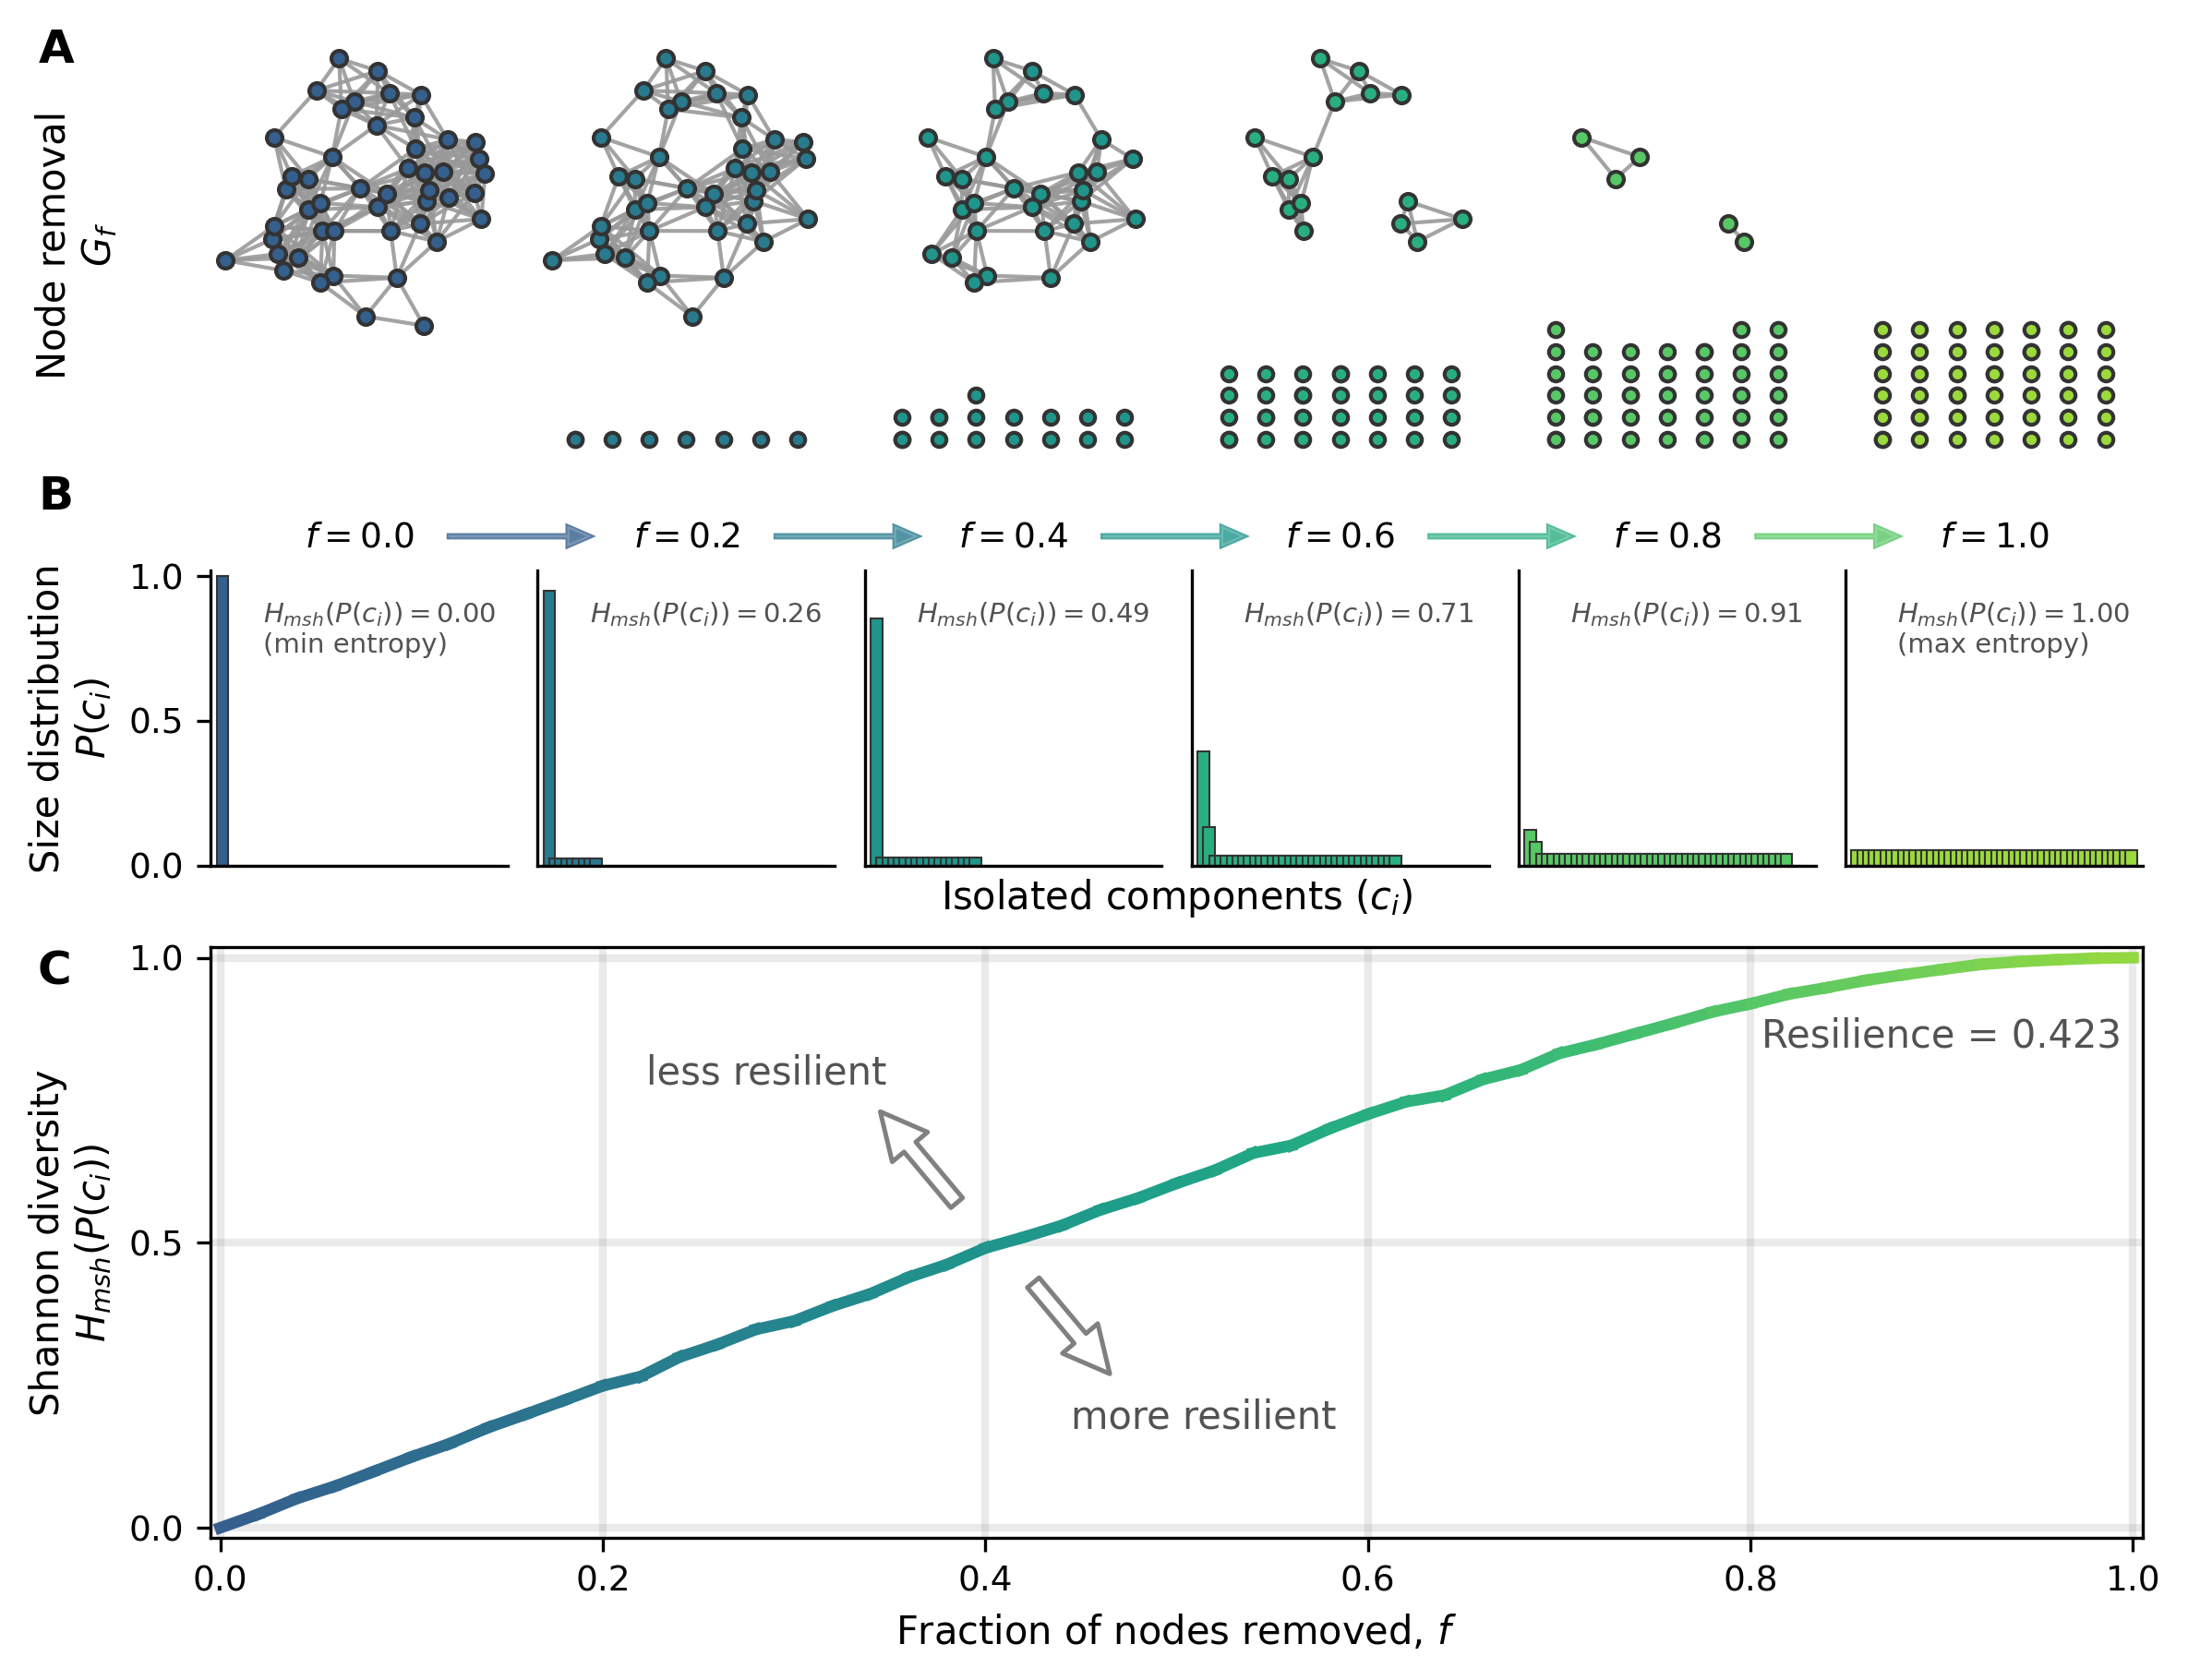

In [48]:
plt.figure(dpi=300, figsize=(9,7))

gs = gridspec.GridSpec(nrows, ncols, width_ratios=[1]*ncols, height_ratios=[1.5, 1, 2])
G_f = G.copy()
remove_nodes = []

# for each of ncol fractions of nodes to remove
for i in range(ncols):
    axi = plt.subplot(gs[i])
    f = fs[i]
    fx = f
    if i > 0:
        fx = fx*0.8
    
    if i == ncols-1:
        fx = f
        
    remove_nodes_i = [i for i in G_f.nodes() if np.random.rand() < fx]
    
    if len(remove_nodes_i):
        for node_r in remove_nodes_i:
            remove_nodes.append(node_r)
            G_f.remove_node(node_r)
            G_f.add_node(node_r)
    
    remove_nodes = list(set(remove_nodes))
    Cs = sorted(list(nx.connected_components(G_f)),key=len,reverse=True)
    vals = list(range(len(G)))
    counts = [0]*len(vals)
    for j,Ci in enumerate(Cs):
        counts[j] += len(Ci) / G.number_of_nodes()
    
    nc = cols[i]
    nodelist = [i for i in G.nodes() if i not in remove_nodes]
    nx.draw_networkx_nodes(G_f,pos_i,nodelist=nodelist,node_size=ns*1.1,edgecolors='#333333',
                           linewidths=1,node_color=[nc],ax=axi)
    nx.draw_networkx_edges(G_f,pos_i,width=ew,edge_color='#999999',ax=axi,alpha=0.9)
    
    if i==0:
        axi.text(-0.45, 0.55,'Node removal\n$G_{f}$',fontsize=10,transform=axi.transAxes,
             verticalalignment='center',horizontalalignment='center',clip_on=False,rotation=90)
        axi.text(-0.58, 0.99,'A',fontsize=12,transform=axi.transAxes,fontweight='semibold',
             verticalalignment='center',horizontalalignment='left',clip_on=False)
        
    axi.set_xticks([])
    axi.set_yticks([])

    yvals = np.linspace(min(ycoords)*2.0,max(ycoords*1.1),20)
    xvals = np.linspace(min(xcoords)*1.1,max(xcoords*1.2),9)
    
    for iso in range(len(remove_nodes)):
        yv = yvals[1 + int(iso/8)]
        xv = xvals[1 + (iso%7)]
        axi.scatter([xv],[yv],c=[cols[i]],s=ns/1.1,edgecolors=['#333333'])

    axi.set_ylim(min(yvals)*1.1,max(yvals))
    axi.set_xlim(min(xvals),max(xvals))
    axi.set_axis_off()

    ##############################################################
    axi = plt.subplot(gs[i+ncols])
    axi.tick_params(axis='both', which='major', labelsize=6)
    
    ent = np.abs(np.round(modified_shannon_entropy(G,f),3))
    lab = '$H_{msh}(P(c_i))=%.2f$'%ent
    axi.set_xticks([])
    axi.set_yticks([])

    if i==0:
        lab = '$H_{msh}(P(c_i))=%.2f$\n(min entropy)'%ent
        axi.set_ylabel('Size distribution\n$P(c_i)$',fontsize=10)
        axi.set_yticks(np.linspace(0,1,3))
        axi.tick_params(axis='both', which='major', labelsize=9)
        axi.text(-0.58, 1.25,'B',fontsize=12,transform=axi.transAxes,fontweight='semibold',
             verticalalignment='center',horizontalalignment='left',clip_on=False)

    if i==ncols-1:
        lab = '$H_{msh}(P(c_i))=%.2f$\n(max entropy)'%ent

    else:
        maxb = max(counts)
        axi.arrow(0.8, 1.115, 0.4, 0, head_width=0.07, head_length=0.08, width=0.008,
                  fc=cols[i], ec=cols[i],transform=axi.transAxes,clip_on=False)
        axi.arrow(0.8, 1.115, 0.4, 0, head_width=0.07, head_length=0.08, width=0.008,
                  fc='w', ec='w',transform=axi.transAxes,clip_on=False,alpha=0.2)
        
    maxy = np.linspace(1.02,0.4,ncols)
    axi.set_ylim(0,maxy[i])
    axi.bar(vals,counts,color=cols[i],width=2,edgecolor='#333333',linewidth=0.5, label=lab)
    
    axi.text(0.175,0.9,lab,fontsize=7,transform=axi.transAxes,color='#525252',
             verticalalignment='top',horizontalalignment='left')

    axi.set_xlim(-2,G.number_of_nodes()+1)
    axi.spines['top'].set_visible(False)
    axi.spines['right'].set_visible(False)
    axi.set_title('$f = %.1f$'%f, fontsize=9,y=1)#0.97)
    
    ##############################################################

rate = 51
ents = resilience(G, rate=rate, output_list=True)
xents = np.linspace(0,1,len(ents))
axi = plt.subplot(gs[nrows-1,:])

cols_bot = plt.cm.viridis(np.linspace(0.3,0.85,len(ents)))
for i in range(len(ents)-1):
    axi.plot([xents[i],xents[i+1]], [ents[i],ents[i+1]], color=cols_bot[i], linewidth=3.0)

axi.annotate("", xy=(0.34, 0.75), xytext=(0.39, 0.55), transform=axi.transAxes,
             arrowprops=dict(shrink=0.1, ec='#808080',fc='w',lw=1.2))
axi.text(0.35, 0.755,'less resilient',fontsize=10,transform=axi.transAxes,color='#525252',
             verticalalignment='bottom',horizontalalignment='right')

axi.annotate("", xy=(0.47, 0.25), xytext=(0.42, 0.45), transform=axi.transAxes,
             arrowprops=dict(shrink=0.1, ec='#808080',fc='w',lw=1.2))
axi.text(0.445, 0.2375,'more resilient',fontsize=10,transform=axi.transAxes,color='#525252',
             verticalalignment='top',horizontalalignment='left')

axi.set_xticks(np.linspace(0,1,6))
axi.set_yticks(np.linspace(0,1,3))
axi.set_xlabel('Fraction of nodes removed, $f$',fontsize=10)
axi.set_ylabel('Shannon diversity\n$H_{msh}(P(c_i))$',fontsize=10)
axi.set_xlim(-0.005,1.005)
axi.set_ylim(-0.018,1.018)
axi.grid(linewidth=2.0,color='#999999',alpha=0.2)
axi.tick_params(axis='both', which='major', labelsize=9)
axi.set_title('Isolated components ($c_i$)',fontsize=10,y=1.025)
axi.text(-0.09, 0.96,'C',fontsize=12,transform=axi.transAxes,fontweight='semibold',
     verticalalignment='center',horizontalalignment='left',clip_on=False)

axi.text(0.8025, 0.85, "Resilience = %.3f"%(1-sum(ents/rate)),
         fontsize=10,transform=axi.transAxes,color='#525252',
         verticalalignment='center',horizontalalignment='left')

plt.subplots_adjust(wspace=0.1,hspace=0.185)

plt.savefig("../figs/pngs/resilience_intro.png", dpi=600, bbox_inches='tight')
plt.savefig("../figs/pdfs/resilience_intro.pdf", bbox_inches='tight')

plt.show()

In [49]:
from presilience import *
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
from scipy import stats
import scipy as sp
import datetime as dt
import community
from collections import Counter

from utilities import softmax

plt.rc('axes', axisbelow=True)
%matplotlib inline

In [9]:
def add_mutant_node(G,   percentage=0.2):
    """
    Add node to the network according to the method supplied. This new node may
    be added randomly, preferentially based on degree, or using insights about
    empirical distributions of protein-specific interaction patterns (here
    named 'bio_smart', 'random', and 'degree').

    Params
    ------
    G (nx.Graph):
        the (protein-protein interaction) network in question.

    m (int):
        the number of edges that each new node brings to the network.

    method (str):
        the method of node-addition in question. can be any of the following:
            - 'random': adds node's edges randomly.
            - 'degree': adds edges preferentially based on degree.
            - 'bio_smart': adds edges based on gene_expression data.

    alpha (float):
        in case the method=='degree', alpha tunes the preferential attachment
        exponent, which makes node_i more / less likely to attaching its m
        edges to high-degree nodes.

    Returns
    -------
    G (nx.Graph):
        the graph with nodes added.

    """


    nodes = list(G.nodes())
    N = len(nodes)
    probs = [1 / N for i in range(N)]
    eijs = np.random.choice(nodes, size=(1,), replace=False, p=probs)

    #duplicate_node = G.nodes[eijs[0]].copy()
    nchange = int(percentage*len(G.edges(eijs[0])))
    nchange = np.max([1,nchange])
    old_edgelen= np.max([len(list(G.edges(eijs[0]))),1])
        
    new_node_id = N 
    G.add_node(str(new_node_id))
    new_edges = []
    for edge in G.edges(eijs[0]):
        new_edge = list(edge)
        new_edge[0] = str(new_node_id)

        new_edge = tuple(new_edge)
        new_edges.append(new_edge)

    G.add_edges_from(new_edges)
    edges_to_add = [(str(new_node_id), np.random.choice(nodes, replace=False, p=probs)) for _ in range(nchange)]
    G.add_edges_from(edges_to_add)
    
    for i in range(nchange):
        edge_toremove = np.random.randint(len(list(G.edges(str(new_node_id)))), size=1)
        u=list(G.edges(str(new_node_id)))[int(edge_toremove)][0]
        v=list(G.edges(str(new_node_id)))[int(edge_toremove)][1]
        G.remove_edge(u,v)
        
    

    #np.random.randint(len(sl), size=1)
    #edges_to_remove = np.random.choice(list(G.edges(new_node_id)), size=(len(list(G.edges(new_node_id)))), replace=False)
    
    #G.remove_edges_from(edges_to_remove)




    return G

In [51]:
len(G_ecoli.edges())/len(G_ecoli.nodes())


25.09090909090909

0.42320470680111577
0.4344814071802089
0.4348634652795622
0.4359835851121826
0.4341908100037901
0.4348944512013453
0.43476809544366435
0.4356852051896327
0.43626220933232174
0.437609429057776
0.4366707371681233


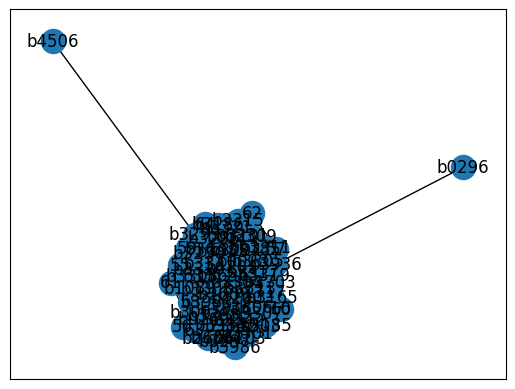

In [52]:
ents = resilience(G, rate=rate, output_list=True)
print(1-sum(ents/rate))
G_f = G_ecoli.copy()
for i in range(10): 
    G_f=add_mutant_node(G_f)
    
    rate = 51
    ents = resilience(G_f, rate=rate, output_list=True)
    print(1-sum(ents/rate))
nx.draw_networkx(G_f)



In [53]:
G_yeast = nx.read_graphml('../data/G_sce.graphml')
G_ecoli = nx.read_graphml('../data/G_eco.graphml')
G_human = nx.read_graphml('../data/G_hsa.graphml')

In [54]:
N = 60
G = nx.barabasi_albert_graph(N, 3)
edges = list(G.edges())
for eij in edges:
    if np.random.rand()<0.2:
        G.remove_edge(eij[0],eij[1])

        

In [55]:
m = 4

nc = 'w'
ec = '.2'
ns_init = 18
num_newnodes = 10
new_nc = plt.cm.OrRd_r(np.linspace(0.0,0.85,num_newnodes))

degs = np.array(list(dict(G.degree()).values()))
pos = nx.kamada_kawai_layout(G)

xcoords = list(list(zip(*list(pos.values())))[0])
ycoords = list(list(zip(*list(pos.values())))[1])
xmin = min(xcoords)
xmax = max(xcoords)
xdiff = xmax-xmin
ymin = min(ycoords)
ymax = max(ycoords)
ydiff = ymax-ymin

In [56]:
def presilience(G, t=4, m=2, method='random', rate=51,
                ntimes=10, output_list=True, printt=True,prob=0.1):
    """
    The 'presilience' is defined as the change in resilience (as calculated
    in Zitnik et al. (2019) using a modified Shannon entropy of the
    cluster size distribution in a network following uniform node removal)
    following the addition of a new node into the network. This new node
    may be added randomly, preferentially based on degree, or using
    insights about empirical distributions of protein-specific interaction
    patterns (named 'bio_smart', 'random', and 'degree').

    Parameters
    ----------
    G (nx.Graph):
        the protein-protein interaction network in question.

    t (int):
        the number of new nodes added (aka the number of timesteps) in the
        future that the presilience will be calculated.

    m (int):
        the number of edges that each new node brings to the network.

    method (str):
        the method of node-addition in question (can be either 'random'--adds
        node's edges randomly, 'degree'--adds edges preferentially based on
        degree, and 'bio_smart'-- which adds edges based on biological data).

    rate (int):
        the number of intervals between 0 and 1, which correspond to fractions
        of the network that are removed at each step.

    n_times (int):
        the number of runs that the algorithm goes through in order to arrive
        at the final (averaged) entropy value.

    output_list (bool):
        if True, returns list of resilience values. else return single number.

    Returns
    -------
    G (nx.Graph):
        the new graph with nodes added

    presilience (list or float):
        a list of resilience values or final resilience

    """

    Gf = G.copy()
    presilience = [resilience(Gf, ntimes, rate, output_list=False)]
    
    if method=="mutation_like":
        
        for new_node in range(t):
            
            Gf = add_mutant_node(Gf,prob)
            res=resilience(Gf, ntimes, rate, output_list=False)
            if printt:
                    
                    print("\t Presilience t =", res, new_node)
            presilience.append(res)
        if output_list:
                return Gf, presilience
        else:
                return Gf, presilience[-1]
    else:
            Gx = G.copy()
            for new_node in range(t):
                if printt:
                    print("\t Presilience t =", new_node)

                Gx = add_node(Gx, m, new_node, method)
                presilience.append(resilience(Gx, ntimes, rate, output_list=False))

            if output_list:
                return Gx, presilience
            else:
                return Gx, presilience[-1]

In [57]:
niter = 6
t_out = 10
r_out = 51
ms = [4,8,16]
ms = [4]

graph_dict = {'G_yeast':G_yeast, 'G_ecoli':G_ecoli, 'G_human':G_human}

out_dict_rand = {'G_yeast':{m_i:[] for m_i in ms},
            'G_ecoli':{m_i:[] for m_i in ms},
            'G_human':{m_i:[] for m_i in ms}}

for Gname in out_dict_rand.keys():
    Gx = graph_dict[Gname]
    for m_i in ms:
        print(Gname, "%02i"%m_i, dt.datetime.now())
        p_i = presilience(Gx, t=t_out, m=m_i, ntimes=niter, rate=r_out, printt=True,prob=0.1)
        out_dict_rand[Gname][m_i] = p_i

G_yeast 04 2023-11-14 14:42:25.118765
	 Presilience t = 0
	 Presilience t = 1
	 Presilience t = 2
	 Presilience t = 3
	 Presilience t = 4
	 Presilience t = 5
	 Presilience t = 6
	 Presilience t = 7
	 Presilience t = 8
	 Presilience t = 9
G_ecoli 04 2023-11-14 14:56:40.299031
	 Presilience t = 0
	 Presilience t = 1
	 Presilience t = 2
	 Presilience t = 3
	 Presilience t = 4
	 Presilience t = 5
	 Presilience t = 6
	 Presilience t = 7
	 Presilience t = 8
	 Presilience t = 9
G_human 04 2023-11-14 14:59:41.313919
	 Presilience t = 0
	 Presilience t = 1
	 Presilience t = 2
	 Presilience t = 3
	 Presilience t = 4
	 Presilience t = 5
	 Presilience t = 6
	 Presilience t = 7
	 Presilience t = 8
	 Presilience t = 9


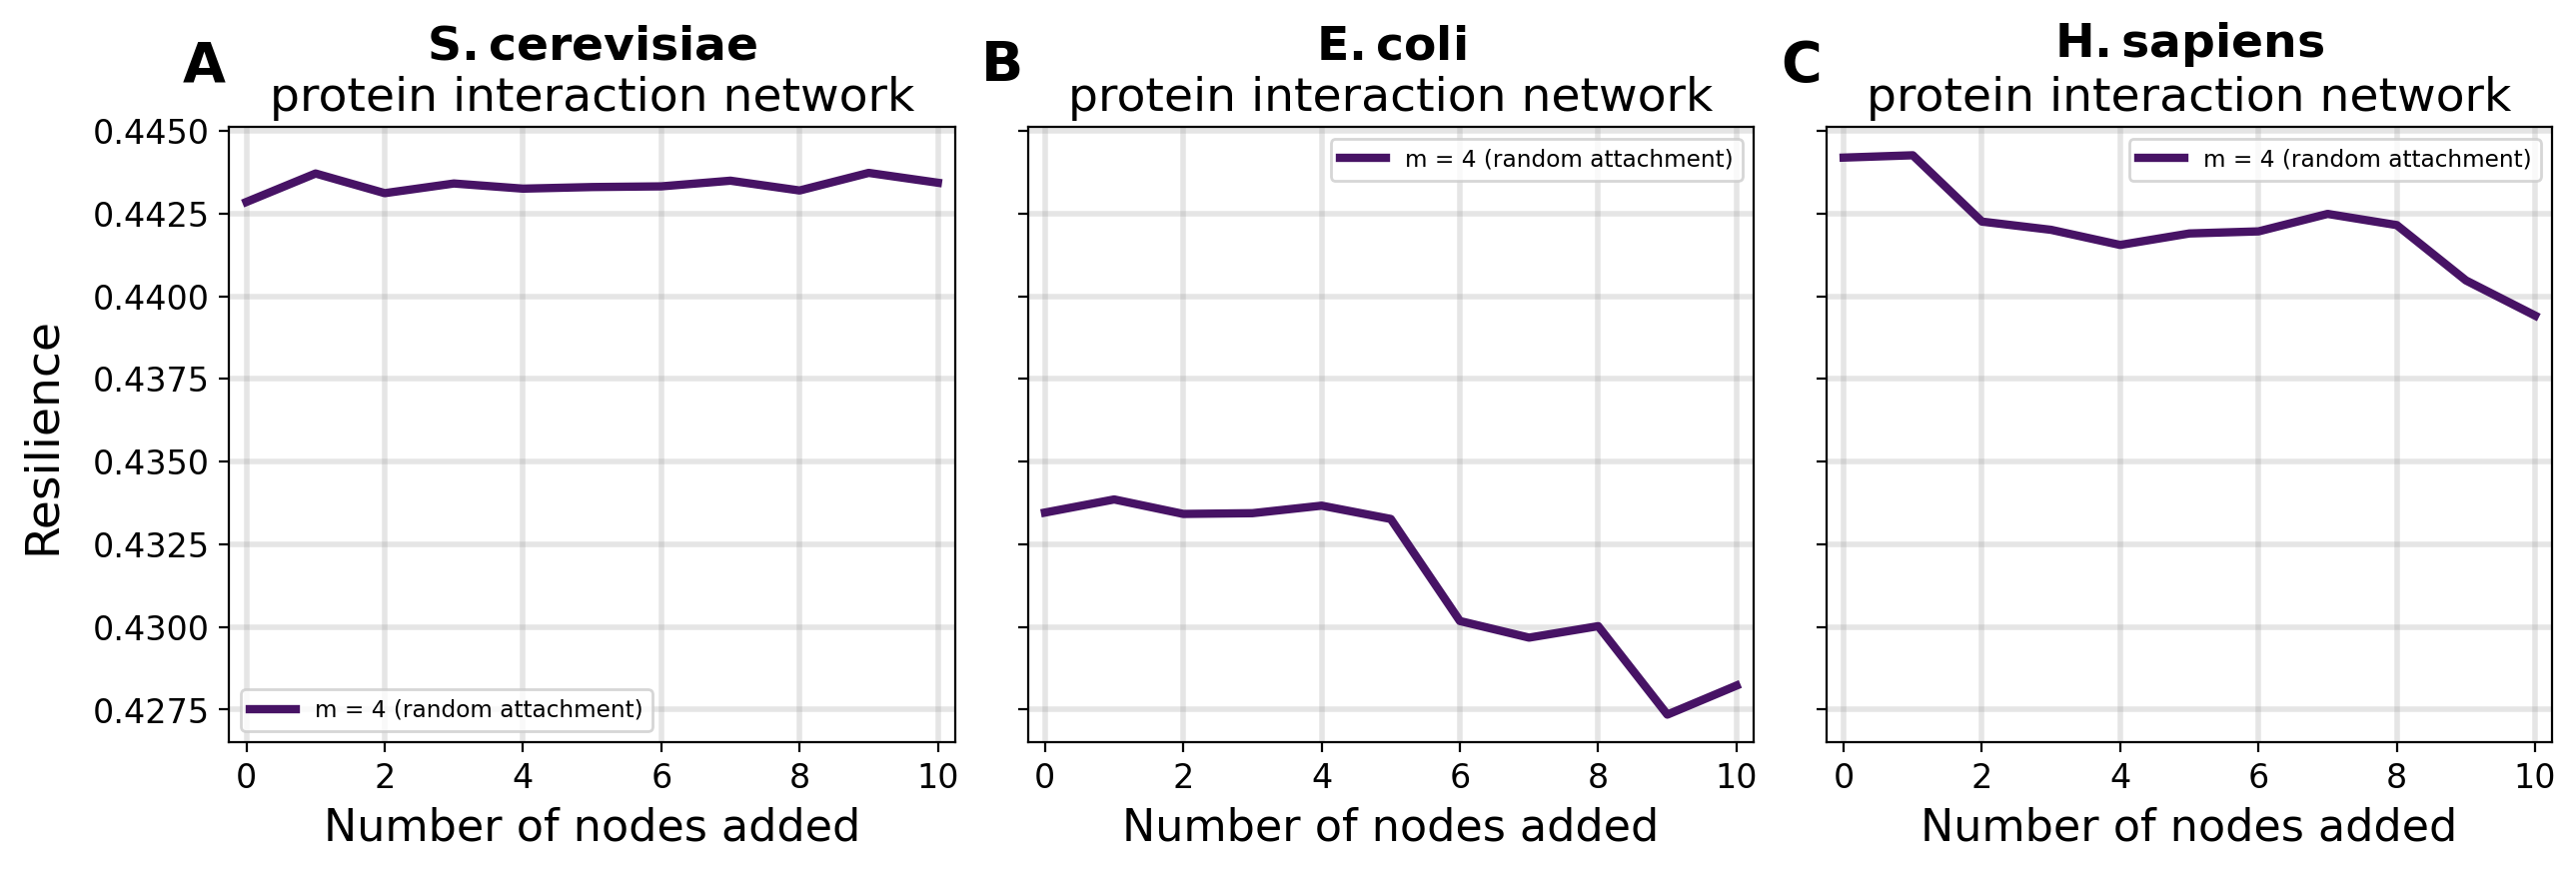

In [58]:
titles = {'G_yeast':r"$\bf{S. cerevisiae}$"+"\nprotein interaction network",
          'G_ecoli':r"$\bf{E. coli}$"+"\nprotein interaction network",
          'G_human':r"$\bf{H. sapiens}$"+"\nprotein interaction network"}

axes = {'G_yeast':0, 'G_ecoli':1, 'G_human':2}

cols = plt.cm.viridis(np.linspace(0.05,0.95,len(ms)))
cols = dict(zip(ms,cols))

fig, ax = plt.subplots(1, 3, figsize=(15,4), dpi=200, sharey=True)
plt.subplots_adjust(hspace=0.015, wspace=0.1)

for Gname, m_data in out_dict_rand.items():
    a = axes[Gname]
    for m_i in m_data.keys():
        ax[a].plot(range(t_out+1), m_data[m_i][1], linewidth=3,
                   color=cols[m_i], label='m = %i (random attachment)'%m_i)

    
    ax[a].grid(linestyle='-', linewidth=2, alpha=0.25, color='#999999')
    ax[a].set_xlabel("Number of nodes added", fontsize=16)
    ax[a].set_xticks(np.linspace(0, 10, 6))
    ax[a].set_xticklabels(np.linspace(0, 10, 6,dtype=int))
    ax[a].set_xlim(-0.25,10.25)
    ax[a].tick_params(axis='both', which='major', labelsize=12)
    
    ax[a].legend(fontsize='small')
    ax[a].set_title(titles[Gname],fontsize=17)    

    
alphabet = ['A', 'B', 'C']
for ai, a in enumerate(fig.axes):
    a.text(-0.035, 1.1, alphabet[ai], fontsize=20, horizontalalignment='center',
           verticalalignment='center', transform=a.transAxes, fontweight='bold')

ax[0].set_ylabel("Resilience", fontsize=17, labelpad=10)

# plt.savefig('../figs/pngs/sample_presilience_randomattachment.png',dpi=425,bbox_inches='tight')
# plt.savefig('../figs/pdfs/sample_presilience_randomattachment.pdf',bbox_inches='tight')
plt.show()

In [59]:
niter = 6
t_out = 10
r_out = 51

ms = [4]

graph_dict = {'G_yeast':G_yeast, 'G_ecoli':G_ecoli, 'G_human':G_human}

out_dict = {'G_yeast':{m_i:[] for m_i in ms},
            'G_ecoli':{m_i:[] for m_i in ms},
            'G_human':{m_i:[] for m_i in ms}}

for Gname in out_dict.keys():
    Gx = graph_dict[Gname]
    for m_i in ms:
        print(Gname, "%02i"%m_i, dt.datetime.now())
        p_i = presilience(Gx, t=t_out, m=m_i, method="mutation_like",ntimes=niter, rate=r_out, printt=True,prob=0.1)
        out_dict[Gname][m_i] = p_i

G_yeast 04 2023-11-14 15:05:19.672852


	 Presilience t = 0.4424230187877376 0
	 Presilience t = 0.44255902669959324 1
	 Presilience t = 0.44215445251569807 2
	 Presilience t = 0.4432243335576477 3
	 Presilience t = 0.4432700094116855 4
	 Presilience t = 0.44291247716591853 5
	 Presilience t = 0.44273589331255836 6
	 Presilience t = 0.4434297549663011 7
	 Presilience t = 0.4441903371108862 8
	 Presilience t = 0.4442224238768028 9
G_ecoli 04 2023-11-14 15:19:45.707545
	 Presilience t = 0.4345979392947208 0
	 Presilience t = 0.434482019495799 1
	 Presilience t = 0.435085072198926 2
	 Presilience t = 0.43519969268462266 3
	 Presilience t = 0.4356612394518965 4
	 Presilience t = 0.43586348766046734 5
	 Presilience t = 0.43588134581753823 6
	 Presilience t = 0.43664684529012554 7
	 Presilience t = 0.4370673248200453 8
	 Presilience t = 0.4368940315017579 9
G_human 04 2023-11-14 15:23:13.542851
	 Presilience t = 0.44466894010395097 0
	 Presilience t = 0.4445704522173719 1
	 Presilience t = 0.44444487665188337 2
	 Presilience t = 0

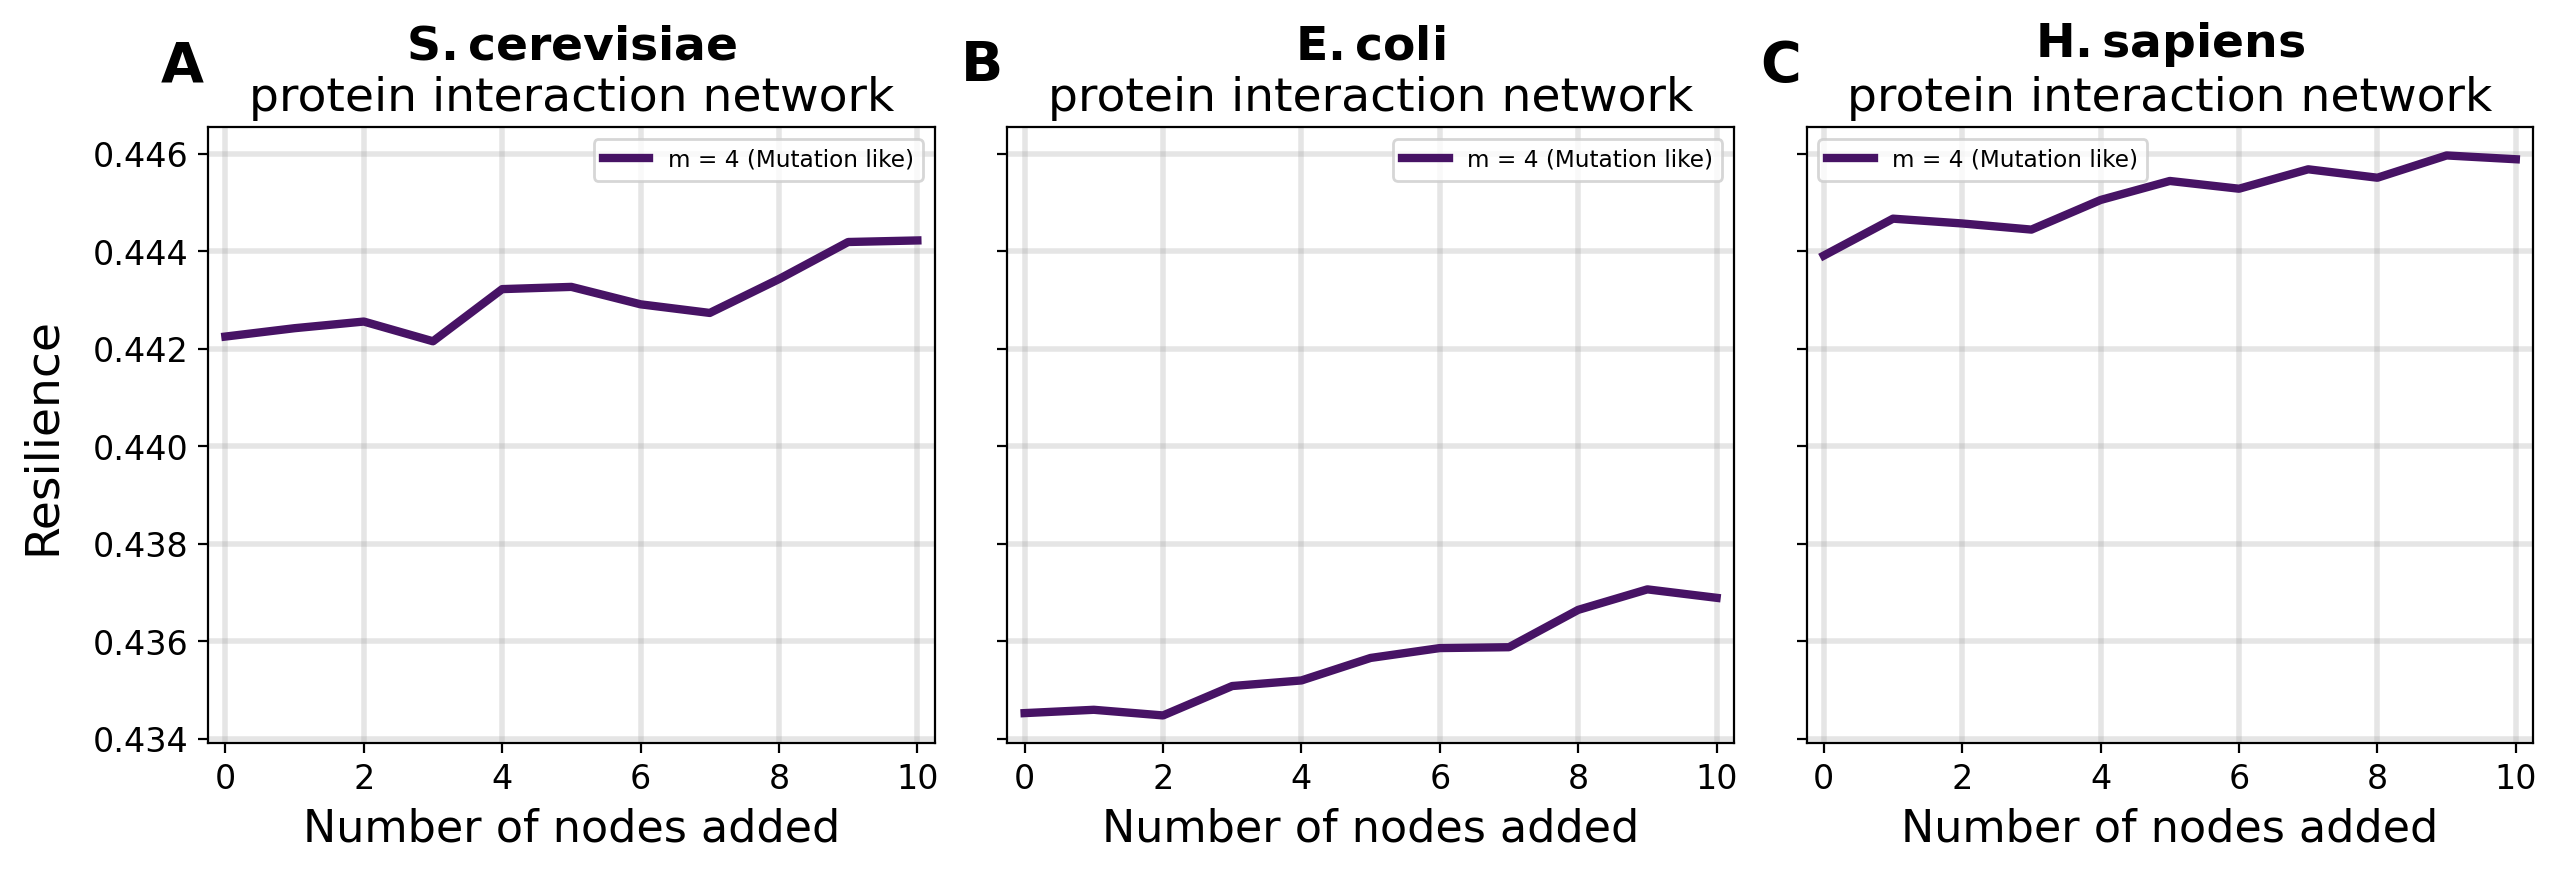

In [60]:
titles = {'G_yeast':r"$\bf{S. cerevisiae}$"+"\nprotein interaction network",
          'G_ecoli':r"$\bf{E. coli}$"+"\nprotein interaction network",
          'G_human':r"$\bf{H. sapiens}$"+"\nprotein interaction network"}

axes = {'G_yeast':0, 'G_ecoli':1, 'G_human':2}

cols = plt.cm.viridis(np.linspace(0.05,0.95,len(ms)))
cols = dict(zip(ms,cols))

fig, ax = plt.subplots(1, 3, figsize=(15,4), dpi=200, sharey=True)
plt.subplots_adjust(hspace=0.015, wspace=0.1)

for Gname, m_data in out_dict.items():
    a = axes[Gname]
    for m_i in m_data.keys():
        ax[a].plot(range(t_out+1), m_data[m_i][1], linewidth=3,
                   color=cols[m_i], label='m = %i (Mutation like)'%m_i)

    
    ax[a].grid(linestyle='-', linewidth=2, alpha=0.25, color='#999999')
    ax[a].set_xlabel("Number of nodes added", fontsize=16)
    ax[a].set_xticks(np.linspace(0, 10, 6))
    ax[a].set_xticklabels(np.linspace(0, 10, 6,dtype=int))
    ax[a].set_xlim(-0.25,10.25)
    ax[a].tick_params(axis='both', which='major', labelsize=12)
    
    ax[a].legend(fontsize='small')
    ax[a].set_title(titles[Gname],fontsize=17)    

    
alphabet = ['A', 'B', 'C']
for ai, a in enumerate(fig.axes):
    a.text(-0.035, 1.1, alphabet[ai], fontsize=20, horizontalalignment='center',
           verticalalignment='center', transform=a.transAxes, fontweight='bold')

ax[0].set_ylabel("Resilience", fontsize=17, labelpad=10)

# plt.savefig('../figs/pngs/sample_presilience_randomattachment.png',dpi=425,bbox_inches='tight')
# plt.savefig('../figs/pdfs/sample_presilience_randomattachment.pdf',bbox_inches='tight')
plt.show()

2
1


'\nnew_G = add_mutant_node(new_G,prob)\nnx.number_connected_components(new_G)\nnew_G = add_mutant_node(new_G,prob)\nnx.number_connected_components(new_G)\nnew_G = add_mutant_node(new_G,prob)\nnx.number_connected_components(new_G) \n'

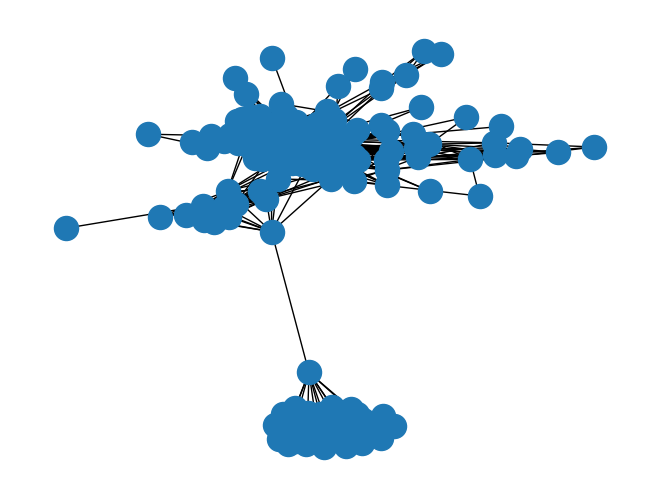

In [61]:
G  = G_yeast.copy()
prob=0.2
G1 = nx.erdos_renyi_graph(G.number_of_nodes()//4,nx.density(G))
relabel_dict = {node: str(node+len(G.nodes)) for node in G1.nodes}
G1 = nx.relabel_nodes(G1, relabel_dict)
new_G = nx.compose(G, G1)
print(nx.number_connected_components(new_G))



new_G = add_mutant_node(new_G,0.2)
print(nx.number_connected_components(new_G))



nx.draw(new_G)
"""
new_G = add_mutant_node(new_G,prob)
nx.number_connected_components(new_G)
new_G = add_mutant_node(new_G,prob)
nx.number_connected_components(new_G)
new_G = add_mutant_node(new_G,prob)
nx.number_connected_components(new_G) 
"""

In [62]:
def Integration_time(G,prob,N_rep):
    
    times= []
    for i in range(N_rep):
        G1 = nx.erdos_renyi_graph(10,nx.density(G))
        relabel_dict = {node: str( node+len(G.nodes)) for node in G1.nodes}
        G1 = nx.relabel_nodes(G1, relabel_dict)
        new_G = nx.compose(G, G1)
        t=0
        while nx.number_connected_components(new_G) !=1 and t<10000:
            new_G = add_mutant_node(new_G,prob)
            t+=1
        times.append(t)
 
    return times#, new_G
    
def test_resiliance(G,prob,N_add,N_rep):
    resiliance= []
    for i in range(N_rep):
        G_f  = G.copy()
        for i in range(N_add): 
            G_f=add_mutant_node(G_f, prob)
        rate = 51
        ents = resilience(G_f, rate=rate, output_list=True)
        resiliance.append(1-sum(ents/rate))
    return np.mean(resiliance),resiliance


def Integration_time_resiliance(G,prob,N_rep, N_addioional):
    
    times= []
    resiliance_tint = []
    resiliance_tadd = []
    rate=51
    for i in range(N_rep):
        for i in range(100):
            G1 = nx.erdos_renyi_graph(10,nx.density(G))
            relabel_dict = {node: str(node+len(G.nodes)) for node in G1.nodes}
            G1 = nx.relabel_nodes(G1, relabel_dict)
            new_G = nx.compose(G, G1)
            t=0
            while nx.number_connected_components(new_G) !=1 and t<1000:
                new_G = add_mutant_node(new_G,prob)
                t+=1
            times.append(t)
        ents = resilience(new_G, rate=rate, output_list=True)
        resiliance_tint.append(1-sum(ents/rate))
        for i in  range(N_addioional):
            new_G = add_mutant_node(new_G,prob)
        ents = resilience(new_G, rate=rate, output_list=True)
        resiliance_tadd.append(1-sum(ents/rate))
        print(t,resiliance_tint,resiliance_tadd)
 
    return times, resiliance_tint, resiliance_tadd

In [63]:
prob_list = [0.01, 0.02,0.03, 0.05, 0.075, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
#prob_list = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4]
G  = G_yeast.copy()
Times = []
Resliances=[]
for prob in prob_list:
    G  = G_yeast.copy()
    times = Integration_time(G,prob,100)
    print(times)
    avg_t = np.mean(times)
    
    Times.append(avg_t)
    res, res_list = test_resiliance(G,prob,30,15)
    print(res)
    print(np.min(res_list),np.std(res_list))
    Resliances.append(res)


[21, 29, 131, 2, 585, 176, 35, 107, 8, 209, 1, 15, 15, 9, 634, 8, 2, 180, 38, 48, 2, 66, 4, 129, 14, 9, 36, 20, 197, 7, 5, 42, 14, 17, 40, 1005, 1201, 10, 15, 11, 30, 44, 1762, 4, 14, 232, 196, 111, 62, 48, 405, 40, 9, 10, 8, 34, 2000, 8, 27, 26, 1619, 94, 60, 20, 1034, 15, 506, 11, 8, 20, 516, 15, 10, 29, 12, 15, 29, 50, 7, 13, 1686, 5, 38, 39, 2, 9, 326, 116, 15, 12, 25, 1217, 16, 6, 12, 6, 6, 7, 6, 1565]
0.4442029333118946
0.44264664277478205 0.0006673217857422963
[194, 13, 6, 10, 5, 79, 2, 2, 259, 15, 4, 1, 6, 5, 6, 6, 32, 777, 178, 10, 806, 7, 582, 7, 32, 27, 11, 1, 507, 25, 6, 14, 4, 35, 1113, 2, 813, 29, 6, 502, 33, 5, 46, 1, 2, 287, 7, 144, 7, 35, 8, 33, 3, 14, 34, 1423, 2, 12, 6, 16, 677, 2, 1433, 49, 334, 72, 42, 12, 178, 18, 43, 17, 34, 5, 6, 593, 26, 1, 134, 474, 1, 228, 7, 24, 7, 16, 72, 5, 8, 18, 21, 25, 79, 12, 374, 245, 13, 10, 1, 790]
0.4438369469876497
0.4424175397396227 0.0008021265884473006
[115, 4, 5, 58, 14, 10, 6, 195, 3, 17, 194, 15, 208, 240, 8, 4, 4, 12, 11, 4

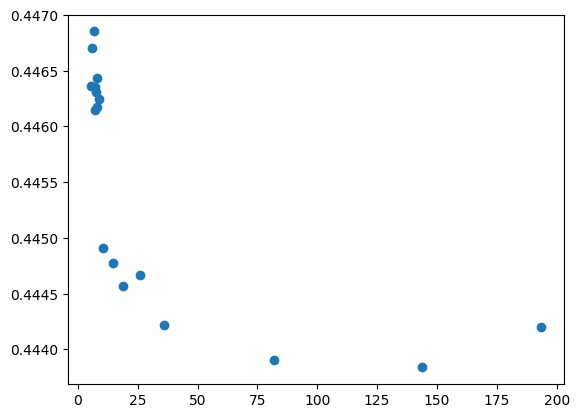

In [64]:
plt.scatter(Times,Resliances)

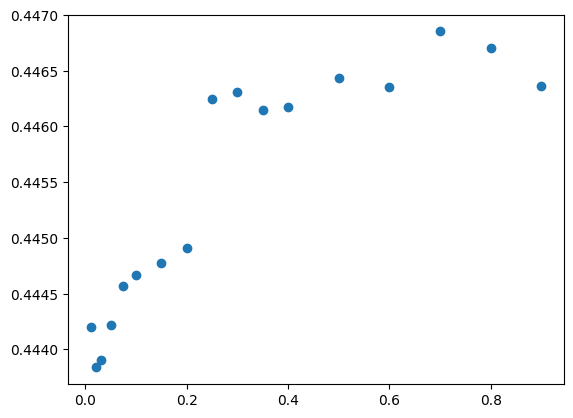

In [65]:
plt.scatter(prob_list,Resliances)

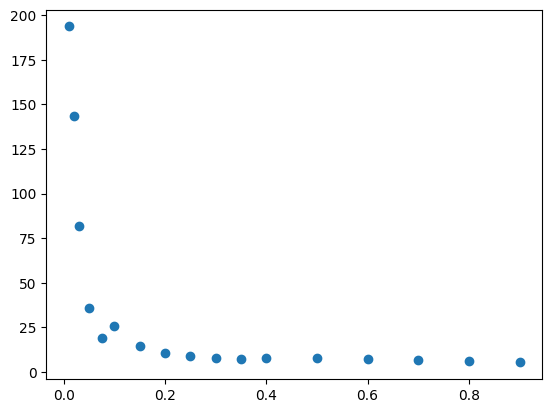

In [66]:
plt.scatter(prob_list, Times)

In [67]:
Times2 = []
Resliances2=[]
Res_add = []
prob_list = [0.01, 0.02,0.03, 0.05, 0.075, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
G  = G_yeast.copy()

for prob in prob_list:
    G  = G_yeast.copy()

    t, resint, resadd = Integration_time_resiliance(G, prob, 30, 10)
    avg_t = np.mean(t)
    print(avg_t)
    avg_resint = np.mean(resint)
    print(avg_resint)
    avg_resadd = np.mean(resadd)
    print(avg_resadd)
    Times2.append(avg_t)
    Resliances2.append(avg_resint)
    Res_add.append(avg_resadd)



6 [0.4336456383696694] [0.43495419792732115]
451 [0.4336456383696694, 0.4600370114201766] [0.43495419792732115, 0.46024581835399836]
60 [0.4336456383696694, 0.4600370114201766, 0.4391385237496832] [0.43495419792732115, 0.46024581835399836, 0.44120573067537905]
102 [0.4336456383696694, 0.4600370114201766, 0.4391385237496832, 0.44850914207466885] [0.43495419792732115, 0.46024581835399836, 0.44120573067537905, 0.44979916900135475]
10 [0.4336456383696694, 0.4600370114201766, 0.4391385237496832, 0.44850914207466885, 0.43212279139767185] [0.43495419792732115, 0.46024581835399836, 0.44120573067537905, 0.44979916900135475, 0.4343032540729215]
232.32
0.442690621402374
0.44410163400619496
17 [0.4347792532208935] [0.43866800058717104]
3 [0.4347792532208935, 0.4328258068005413] [0.43866800058717104, 0.4365550210984437]
4 [0.4347792532208935, 0.4328258068005413, 0.4343076590926289] [0.43866800058717104, 0.4365550210984437, 0.43767559815931334]
6 [0.4347792532208935, 0.4328258068005413, 0.4343076590

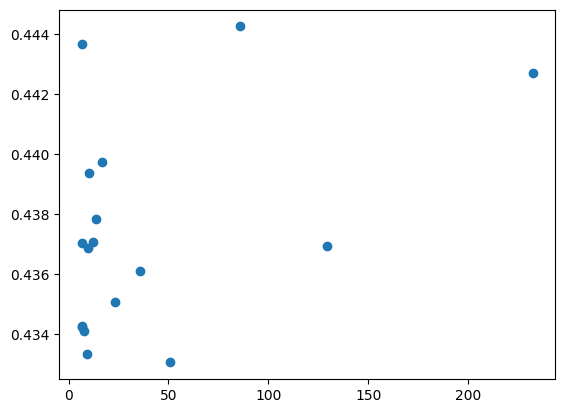

In [69]:
plt.scatter(Times2,Resliances2)

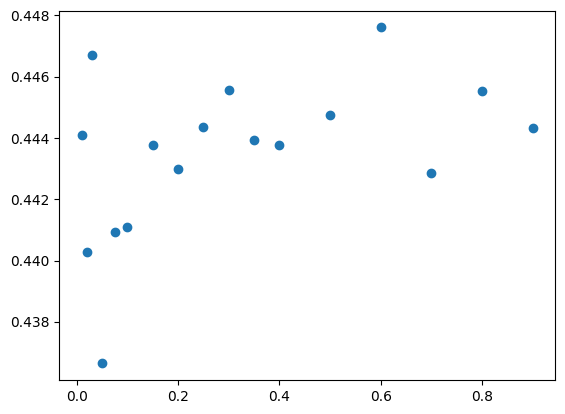

In [71]:
plt.scatter(prob_list,Res_add)

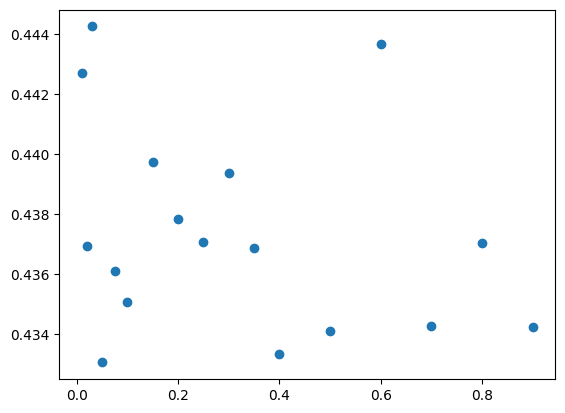

In [73]:
plt.scatter(prob_list,Resliances2)

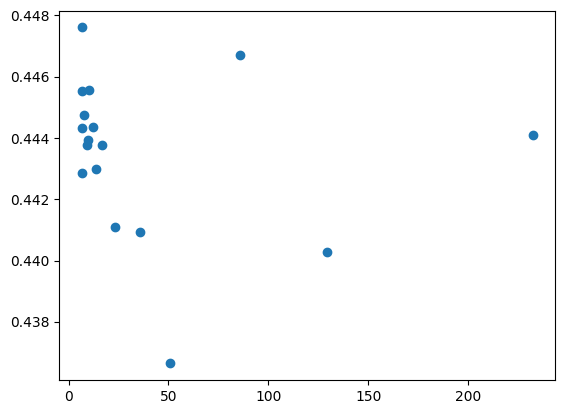

In [74]:
plt.scatter(Times2,Res_add)

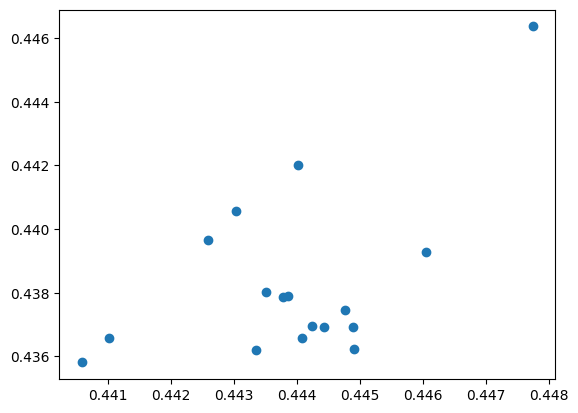

In [86]:
plt.scatter(Res_add,Resliances2)

In [75]:
import community
def modularience(G, t=4, m=2, method='random', output_list=True, printt=True,prob=0.1):
    """
    The 'modularience' is defined as the change in modularity of the
    community-detected partition following the following the
    addition of a new node into the network. This new node may be
    added randomly, preferentially based on degree, or using insights
    about empirical distributions of protein-specific interaction
    patterns (named 'bio_smart', 'random', and 'degree').

    Parameters
    ----------
    G (nx.Graph):
        the protein-protein interaction network in question.

    t (int):
        the number of new nodes added (aka the number of timesteps) in the
        future that the presilience will be calculated.

    m (int):
        the number of edges that each new node brings to the network.

    method (str):
        the method of node-addition in question (can be either 'random'--adds
        node's edges randomly, 'degree'--adds edges preferentially based on
        degree, and 'bio_smart'-- which adds edges based on biological data).

    output_list (bool):
        if True, returns list of resilience values. else return single number.

    Returns
    -------
    G (nx.Graph):
        the new graph with nodes added.

    modularience (list or float):
        a list of modularity values or final modularity.

    """
    import networkx.algorithms.community as nx_comm

    from networkx.algorithms.community import greedy_modularity_communities
    Gx = G.copy()
    communities = greedy_modularity_communities(Gx, weight="weight")
    coms = [len(communities)]
    modularit = [round(nx_comm.modularity(Gx,communities),3)]
    if method=="mutant":
        for new_node in range(t):
            if printt:
                print("\t Modularience t =", new_node)

            Gx = add_mutant_node(new_G,prob)
            communities = greedy_modularity_communities(Gx, weight="weight")
            modularit.append(round(nx_comm.modularity(Gx,communities),3))
            coms.append(len(communities))
    else:    
        for new_node in range(t):
            if printt:
                print("\t Modularience t =", new_node)

            Gx = add_node(Gx, m, str(new_node), method)
            partition = community.best_partition(Gx)
            modularit.append(community.modularity(partition, Gx))

    if output_list:
        return Gx, modularit,coms
    else:
        return Gx, modularit[-1],coms

In [76]:
import networkx.algorithms.community as nx_comm

from networkx.algorithms.community import greedy_modularity_communities
def Integration_time_resiliance_Mod(G,prob,N_rep, N_addioional):
    
    times= []
    resiliance_tint = []
    resiliance_tadd = []
    coms_add = []
    modularit_add = []
    rate=51
    for i in range(N_rep):
        communities = greedy_modularity_communities(Gx, weight="weight")
        coms = [len(communities)]
        modularit = [round(nx_comm.modularity(Gx,communities),3)]
        for i in range(100):
            G1 = nx.erdos_renyi_graph(10,nx.density(G))
            relabel_dict = {node: str(node+len(G.nodes)) for node in G1.nodes}
            G1 = nx.relabel_nodes(G1, relabel_dict)
            new_G = nx.compose(G, G1)
            t=0
            while nx.number_connected_components(new_G) !=1 and t<1000:
                new_G = add_mutant_node(new_G,prob)
                t+=1
            times.append(t)
        communities = greedy_modularity_communities(new_G, weight="weight")
        modularit.append(round(nx_comm.modularity(new_G,communities),3))
        coms.append(len(communities))
        ents = resilience(new_G, rate=rate, output_list=True)
        resiliance_tint.append(1-sum(ents/rate))
        for i in  range(N_addioional):
            new_G = add_mutant_node(new_G,prob)
        ents = resilience(new_G, rate=rate, output_list=True)
        resiliance_tadd.append(1-sum(ents/rate))
        print(t,resiliance_tint,resiliance_tadd)
        communities = greedy_modularity_communities(new_G, weight="weight")
        modularit_add.append(round(nx_comm.modularity(new_G,communities),3))
        coms_add.append(len(communities))
 
    return times, resiliance_tint, resiliance_tadd,modularit,modularit_add,coms,coms_add

1000 [0.4636883667583186] [0.46390472975779606]
22 [0.4636883667583186, 0.435509120327792] [0.46390472975779606, 0.44014702854815735]
6 [0.4636883667583186, 0.435509120327792, 0.43285047027455914] [0.46390472975779606, 0.44014702854815735, 0.43894967078290903]
32 [0.4636883667583186, 0.435509120327792, 0.43285047027455914, 0.43480214537330597] [0.46390472975779606, 0.44014702854815735, 0.43894967078290903, 0.4351242412442514]
161 [0.4636883667583186, 0.435509120327792, 0.43285047027455914, 0.43480214537330597, 0.4506897723190154] [0.46390472975779606, 0.44014702854815735, 0.43894967078290903, 0.4351242412442514, 0.45169730127257623]
2 [0.4636883667583186, 0.435509120327792, 0.43285047027455914, 0.43480214537330597, 0.4506897723190154, 0.4338907836819246] [0.46390472975779606, 0.44014702854815735, 0.43894967078290903, 0.4351242412442514, 0.45169730127257623, 0.43779214003065303]
64 [0.4636883667583186, 0.435509120327792, 0.43285047027455914, 0.43480214537330597, 0.4506897723190154, 0.43

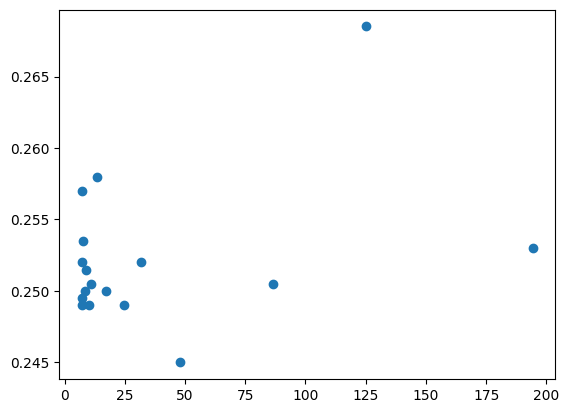

In [89]:
Times2 = []
Resliances2=[]
Res_add = []
mod=[]
mod_add = []
com=[]
com_add = []
prob_list = [0.01, 0.02,0.03, 0.05, 0.075, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
G  = G_yeast.copy()

for prob in prob_list:
    G  = G_yeast.copy()

    t, resint, resadd,modularit,modularit_add, coms,coms_add = Integration_time_resiliance_Mod(G, prob, 50, 10)
    avg_t = np.mean(t)
    print(avg_t)
    avg_resint = np.mean(resint)
    avg_mod = np.mean(modularit)
    avg_mod_add = np.mean(modularit_add)
    avg_resint = np.mean(resint)
    avg_com = np.mean(coms)
    avg_comadd = np.mean(coms_add)
    print(avg_resint)
    avg_resadd = np.mean(resadd)
    print(avg_resadd)
    Times2.append(avg_t)
    Resliances2.append(avg_resint)
    Res_add.append(avg_resadd)
    mod.append(avg_mod)
    mod_add.append(avg_mod_add)
    com.append(avg_com)
    com_add.append(avg_comadd)

plt.scatter(Times2,mod)

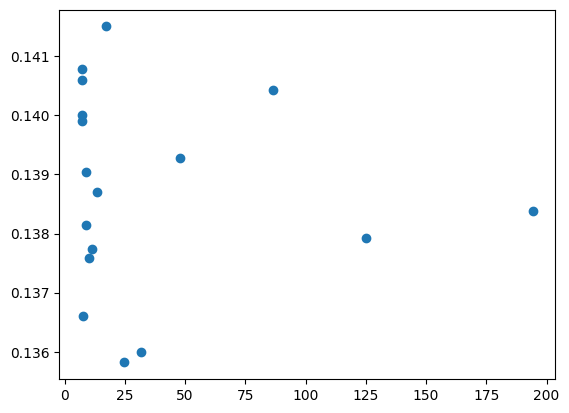

In [90]:
plt.scatter(Times2,mod_add)

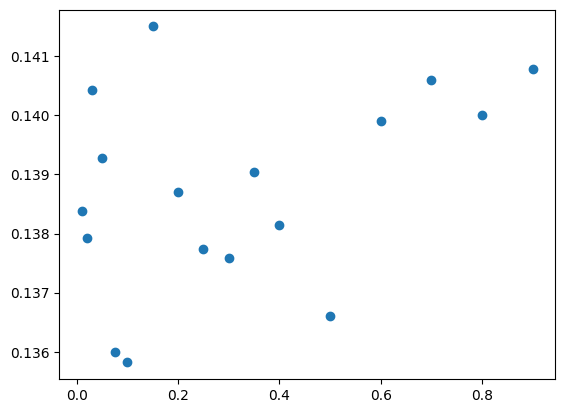

In [91]:
plt.scatter(prob_list,mod_add)

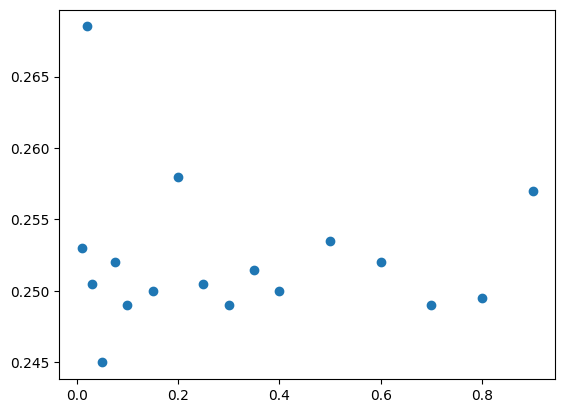

In [92]:
plt.scatter(prob_list,mod)

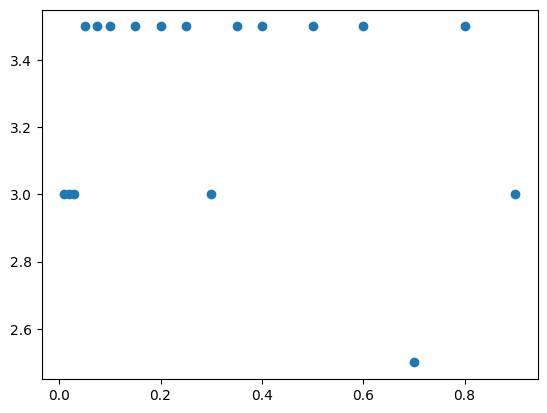

In [93]:
plt.scatter(prob_list,com)

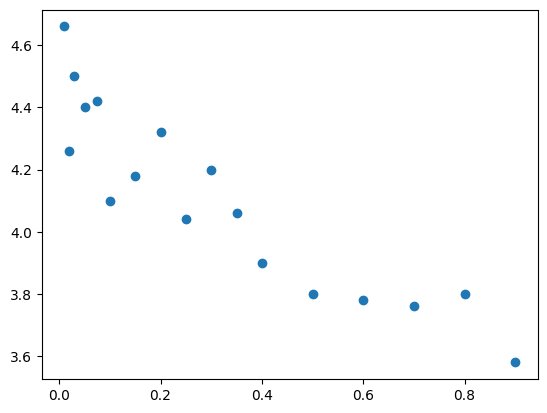

In [94]:
plt.scatter(prob_list,com_add)

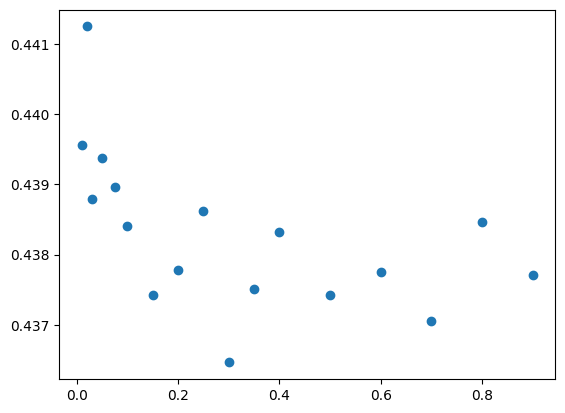

In [95]:
plt.scatter(prob_list,Resliances2)

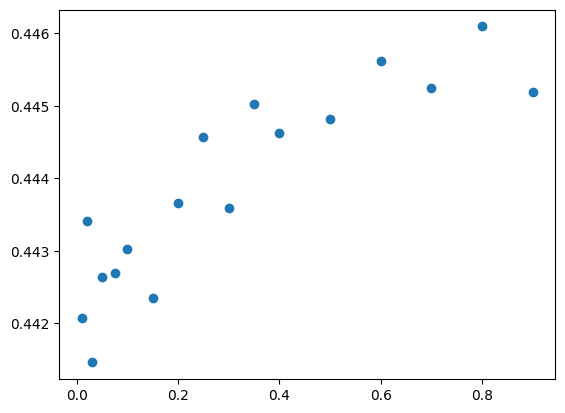

In [96]:
plt.scatter(prob_list,Res_add)

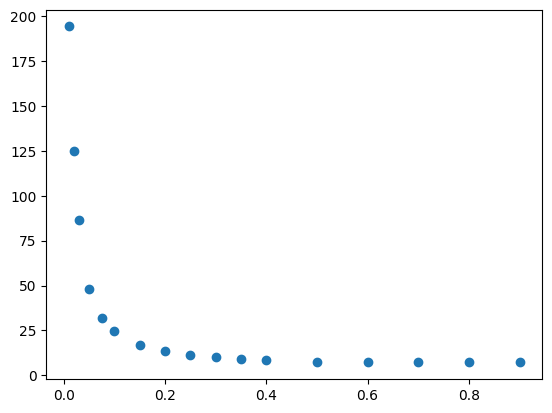

In [97]:
plt.scatter(prob_list,Times2)

/tmp/ipykernel_872327/817432051.py:27: UserWarning: frames=None which we can infer the length of, did not pass an explicit *save_count* and passed cache_frame_data=True.  To avoid a possibly unbounded cache, frame data caching has been disabled. To suppress this warning either pass `cache_frame_data=False` or `save_count=MAX_FRAMES`.
  animation = FuncAnimation(fig,  update,  fargs=(new_G) ) # 10 frames, 1 second interval


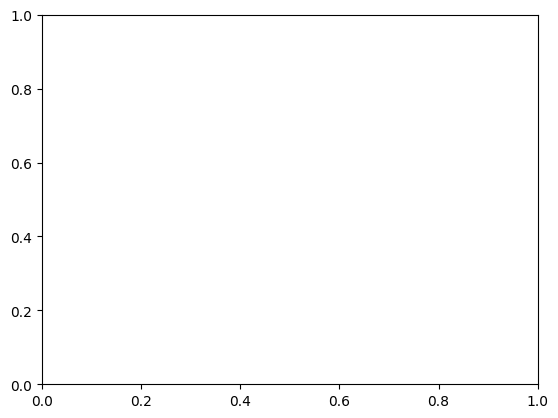

MovieWriter imagemagick unavailable; using Pillow instead.


IndexError: list index out of range

In [48]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
G = nx.read_graphml('../data/G_sce.graphml')

# Create a figure and axis for the plot
fig, ax = plt.subplots()
pos = nx.spring_layout(G)
G1 = nx.erdos_renyi_graph(10,nx.density(G))
relabel_dict = {node: str(node+len(G.nodes)) for node in G1.nodes}
G1 = nx.relabel_nodes(G1, relabel_dict)
new_G = nx.compose(G, G1)

pos = nx.spring_layout(new_G)
# Function to update the plot with the current state of the graph
def update(frame,new_G):
    ax.clear()
    add_mutant_node(new_G,0.2)  # Add 5 nodes at each step (adjust as needed)
    pos = nx.spring_layout(new_G)
    nx.draw(new_G, pos, with_labels=True, ax=ax)

def diffuse_anim(inputs, G, data, nb_frames=50):
    fig = plt.figure()
    nodes = nx.draw_networkx_nodes(G, pos, node_size=30, node_color='b')
    return animation.FuncAnimation(fig, update_func, frames=xrange(nb_frames), fargs=(data, nodes))
# Create an animation
animation = FuncAnimation(fig,  update,  fargs=(new_G) ) # 10 frames, 1 second interval
plt.show()
animation.save("anim.gif", writer='imagemagick')
# Show the animation
